# CommonLit Readability Prize

### Rate the complexity of literary passages for grades 3-12 classroom use

In [1]:
#Import neccessary libraries
import pandas as pd
import requests
import numpy as np
import json
from warnings import filterwarnings
filterwarnings('ignore')

import string
import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
%matplotlib inline

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk import FreqDist

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.ensemble import AdaBoostRegressor

from keras.models import Sequential
from keras.layers import Dense

# EDA

Let's import the data and perform some exploration.

In [2]:
#Import the data
df = pd.read_csv('data/train.csv')
df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [3]:
#drop not-needed columns
df.drop(['id', 'url_legal', 'license'], axis=1, inplace=True)

In [4]:
df

,excerpt,target,standard_error
0,When the young people returned to the ballroom...,-0.340259,0.464009
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,And outside before the palace a great garden w...,-1.054013,0.450007
4,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...
2829,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,The second state of matter we will discuss is ...,0.255209,0.483866
2832,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [5]:
#preview our target variable
df.target.describe()

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64

In [6]:
#explore missing values/NaNs
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   excerpt         2834 non-null   object 
 1   target          2834 non-null   float64
 2   standard_error  2834 non-null   float64
dtypes: float64(2), object(1)
memory usage: 66.5+ KB


Great, no missing values to handle. Next, let's preview what the highest and lowest scored text look like.

In [7]:
#highest target score text
df.excerpt[df[df.target == df.target.max()].index[0]]

'When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs lived in those places, yes. But did you know that some dinosaurs lived in the cold and the darkness near the North and South Poles?\nThis surprised scientists, too. Paleontologists used to believe that dinosaurs lived only in the warmest parts of the world. They thought that dinosaurs could only have lived in places where turtles, crocodiles, and snakes live today. Later, these dinosaur scientists began finding bones in surprising places.\nOne of those surprising fossil beds is a place called Dinosaur Cove, Australia. One hundred million years ago, Australia was connected to Antarctica. Both continents were located near the South Pole. Today, paleontologists dig dinosaur fossils out of the ground. They think about what those ancient bones must mean.'

In [8]:
#lowest target score text
df.excerpt[df[df.target == df.target.min()].index[0]]

'The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120! segments are to be found. These three segments are made so as to be removable in a moment for cleaning or replacement. They are mounted upon a metal support, and are surrounded on all sides by a free air space, and cannot, therefore, lose their insulated condition. This feature of air insulation is peculiar to this system, and is very important as a factor in the durability of the commutator. Besides this, the commutator is sustained by supports carried in flanges upon the shaft, which flanges, as an additional safeguard, are coated all over with hard rubber, one of the finest known insulators. It may be stated, without fear of contradiction, that no other commutator made is so thoroughly insulated and protected. The three commutator segments virtually constitute a single copper ring, mounted i

Seems like the lower the score, the more complex the passages are. This is confirmed via the competition host: https://www.kaggle.com/c/commonlitreadabilityprize/discussion/240423

Now let's take a look at the distributino of our target scores.

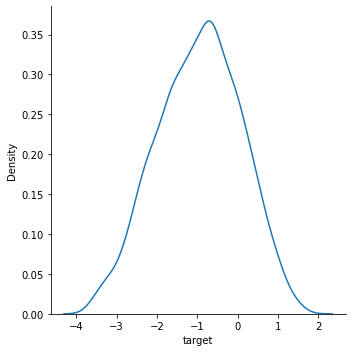

In [9]:
#preview distribution of target variable
sns.displot(df, x="target", kind="kde")

Next, let's clean up some of the text and create some additional fields to model.

In [10]:
#tokenize text and remove punctuation, whitespacs and lowercase text
punct = set(string.punctuation)

def tokenize_text(text):
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in punct]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return nltk.word_tokenize(text_no_doublespace)

In [11]:
#apply the above function and re-join tokenized text
df['excerpt_tokenized'] = df['excerpt'].apply(tokenize_text)
df['excerpt_cleaned'] = df['excerpt_tokenized'].apply(' '.join)
df

,excerpt,target,standard_error,excerpt_tokenized,excerpt_cleaned
0,When the young people returned to the ballroom...,-0.340259,0.464009,"[when, the, young, people, returned, to, the, ...",when the young people returned to the ballroom...
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,"[all, through, dinner, time, mrs, fayre, was, ...",all through dinner time mrs fayre was somewhat...
2,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,"[as, roger, had, predicted, the, snow, departe...",as roger had predicted the snow departed as qu...
3,And outside before the palace a great garden w...,-1.054013,0.450007,"[and, outside, before, the, palace, a, great, ...",and outside before the palace a great garden w...
4,Once upon a time there were Three Bears who li...,0.247197,0.510845,"[once, upon, a, time, there, were, three, bear...",once upon a time there were three bears who li...
...,...,...,...,...,...
2829,When you think of dinosaurs and where they liv...,1.711390,0.646900,"[when, you, think, of, dinosaurs, and, where, ...",when you think of dinosaurs and where they liv...
2830,So what is a solid? Solids are usually hard be...,0.189476,0.535648,"[so, what, is, a, solid, solids, are, usually,...",so what is a solid solids are usually hard bec...
2831,The second state of matter we will discuss is ...,0.255209,0.483866,"[the, second, state, of, matter, we, will, dis...",the second state of matter we will discuss is ...
2832,Solids are shapes that you can actually touch....,-0.215279,0.514128,"[solids, are, shapes, that, you, can, actually...",solids are shapes that you can actually touch ...


In [12]:
#removing stopwords
words = stopwords.words("english")
    
#adding custom words
custom_words = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'first', 'second', 'third',
               'fourth', 'fifth', 'sixth', 'seventh', 'tenth', 'would', 'also', 'could', 'said']
for i in custom_words:
    words.append(i)

words = set(words)

df['excerpt_cleaned'] = df['excerpt_tokenized'].apply(lambda x: [item for item in x if item not in words])
df['excerpt_cleaned'] = df['excerpt_cleaned'].apply(' '.join)
df['excerpt_tokenized'] = df['excerpt_cleaned'].apply(tokenize_text)
df

,excerpt,target,standard_error,excerpt_tokenized,excerpt_cleaned
0,When the young people returned to the ballroom...,-0.340259,0.464009,"[young, people, returned, ballroom, presented,...",young people returned ballroom presented decid...
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,"[dinner, time, mrs, fayre, somewhat, silent, e...",dinner time mrs fayre somewhat silent eyes res...
2,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,"[roger, predicted, snow, departed, quickly, ca...",roger predicted snow departed quickly came day...
3,And outside before the palace a great garden w...,-1.054013,0.450007,"[outside, palace, great, garden, walled, round...",outside palace great garden walled round fille...
4,Once upon a time there were Three Bears who li...,0.247197,0.510845,"[upon, time, bears, lived, together, house, wo...",upon time bears lived together house wood litt...
...,...,...,...,...,...
2829,When you think of dinosaurs and where they liv...,1.711390,0.646900,"[think, dinosaurs, lived, picture, see, hot, s...",think dinosaurs lived picture see hot steamy s...
2830,So what is a solid? Solids are usually hard be...,0.189476,0.535648,"[solid, solids, usually, hard, molecules, pack...",solid solids usually hard molecules packed tog...
2831,The second state of matter we will discuss is ...,0.255209,0.483866,"[state, matter, discuss, liquid, solids, hard,...",state matter discuss liquid solids hard things...
2832,Solids are shapes that you can actually touch....,-0.215279,0.514128,"[solids, shapes, actually, touch, dimensions, ...",solids shapes actually touch dimensions means ...


In [14]:
#POS tagging to lemmatize text
lemmatizer = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_text(text):
    #tokenize text and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_text.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_text)

# Lemmatizing
df['excerpt_pos_lemmatized'] = df['excerpt_cleaned'].apply(lambda x: lemmatize_text(x))
df

,excerpt,target,standard_error,excerpt_tokenized,excerpt_cleaned,excerpt_pos_lemmatized
0,When the young people returned to the ballroom...,-0.340259,0.464009,"[young, people, returned, ballroom, presented,...",young people returned ballroom presented decid...,young people return ballroom present decidedly...
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,"[dinner, time, mrs, fayre, somewhat, silent, e...",dinner time mrs fayre somewhat silent eyes res...,dinner time mrs fayre somewhat silent eye rest...
2,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,"[roger, predicted, snow, departed, quickly, ca...",roger predicted snow departed quickly came day...,roger predict snow departed quickly come day s...
3,And outside before the palace a great garden w...,-1.054013,0.450007,"[outside, palace, great, garden, walled, round...",outside palace great garden walled round fille...,outside palace great garden wall round fill fu...
4,Once upon a time there were Three Bears who li...,0.247197,0.510845,"[upon, time, bears, lived, together, house, wo...",upon time bears lived together house wood litt...,upon time bear live together house wood little...
...,...,...,...,...,...,...
2829,When you think of dinosaurs and where they liv...,1.711390,0.646900,"[think, dinosaurs, lived, picture, see, hot, s...",think dinosaurs lived picture see hot steamy s...,think dinosaur live picture see hot steamy swa...
2830,So what is a solid? Solids are usually hard be...,0.189476,0.535648,"[solid, solids, usually, hard, molecules, pack...",solid solids usually hard molecules packed tog...,solid solid usually hard molecule pack togethe...
2831,The second state of matter we will discuss is ...,0.255209,0.483866,"[state, matter, discuss, liquid, solids, hard,...",state matter discuss liquid solids hard things...,state matter discus liquid solid hard thing ho...
2832,Solids are shapes that you can actually touch....,-0.215279,0.514128,"[solids, shapes, actually, touch, dimensions, ...",solids shapes actually touch dimensions means ...,solid shape actually touch dimension mean leng...


In [15]:
stemmer = SnowballStemmer('english')

df['excerpt_snowball_stemmed'] = df['excerpt_tokenized'].apply(lambda x: [stemmer.stem(word) for word in x])
df['excerpt_snowball_stemmed'] = df['excerpt_snowball_stemmed'].apply(' '.join)
df

,excerpt,target,standard_error,excerpt_tokenized,excerpt_cleaned,excerpt_pos_lemmatized,excerpt_snowball_stemmed
0,When the young people returned to the ballroom...,-0.340259,0.464009,"[young, people, returned, ballroom, presented,...",young people returned ballroom presented decid...,young people return ballroom present decidedly...,young peopl return ballroom present decid chan...
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,"[dinner, time, mrs, fayre, somewhat, silent, e...",dinner time mrs fayre somewhat silent eyes res...,dinner time mrs fayre somewhat silent eye rest...,dinner time mrs fayr somewhat silent eye rest ...
2,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,"[roger, predicted, snow, departed, quickly, ca...",roger predicted snow departed quickly came day...,roger predict snow departed quickly come day s...,roger predict snow depart quick came day sleig...
3,And outside before the palace a great garden w...,-1.054013,0.450007,"[outside, palace, great, garden, walled, round...",outside palace great garden walled round fille...,outside palace great garden wall round fill fu...,outsid palac great garden wall round fill full...
4,Once upon a time there were Three Bears who li...,0.247197,0.510845,"[upon, time, bears, lived, together, house, wo...",upon time bears lived together house wood litt...,upon time bear live together house wood little...,upon time bear live togeth hous wood littl sma...
...,...,...,...,...,...,...,...
2829,When you think of dinosaurs and where they liv...,1.711390,0.646900,"[think, dinosaurs, lived, picture, see, hot, s...",think dinosaurs lived picture see hot steamy s...,think dinosaur live picture see hot steamy swa...,think dinosaur live pictur see hot steami swam...
2830,So what is a solid? Solids are usually hard be...,0.189476,0.535648,"[solid, solids, usually, hard, molecules, pack...",solid solids usually hard molecules packed tog...,solid solid usually hard molecule pack togethe...,solid solid usual hard molecul pack togeth clo...
2831,The second state of matter we will discuss is ...,0.255209,0.483866,"[state, matter, discuss, liquid, solids, hard,...",state matter discuss liquid solids hard things...,state matter discus liquid solid hard thing ho...,state matter discuss liquid solid hard thing h...
2832,Solids are shapes that you can actually touch....,-0.215279,0.514128,"[solids, shapes, actually, touch, dimensions, ...",solids shapes actually touch dimensions means ...,solid shape actually touch dimension mean leng...,solid shape actual touch dimens mean length wi...


In [16]:
stemmer = PorterStemmer()

df['excerpt_porter_stemmed'] = df['excerpt_tokenized'].apply(lambda x: [stemmer.stem(word) for word in x])
df['excerpt_porter_stemmed'] = df['excerpt_porter_stemmed'].apply(' '.join)
df

,excerpt,target,standard_error,excerpt_tokenized,excerpt_cleaned,excerpt_pos_lemmatized,excerpt_snowball_stemmed,excerpt_porter_stemmed
0,When the young people returned to the ballroom...,-0.340259,0.464009,"[young, people, returned, ballroom, presented,...",young people returned ballroom presented decid...,young people return ballroom present decidedly...,young peopl return ballroom present decid chan...,young peopl return ballroom present decidedli ...
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,"[dinner, time, mrs, fayre, somewhat, silent, e...",dinner time mrs fayre somewhat silent eyes res...,dinner time mrs fayre somewhat silent eye rest...,dinner time mrs fayr somewhat silent eye rest ...,dinner time mr fayr somewhat silent eye rest d...
2,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,"[roger, predicted, snow, departed, quickly, ca...",roger predicted snow departed quickly came day...,roger predict snow departed quickly come day s...,roger predict snow depart quick came day sleig...,roger predict snow depart quickli came day sle...
3,And outside before the palace a great garden w...,-1.054013,0.450007,"[outside, palace, great, garden, walled, round...",outside palace great garden walled round fille...,outside palace great garden wall round fill fu...,outsid palac great garden wall round fill full...,outsid palac great garden wall round fill full...
4,Once upon a time there were Three Bears who li...,0.247197,0.510845,"[upon, time, bears, lived, together, house, wo...",upon time bears lived together house wood litt...,upon time bear live together house wood little...,upon time bear live togeth hous wood littl sma...,upon time bear live togeth hous wood littl sma...
...,...,...,...,...,...,...,...,...
2829,When you think of dinosaurs and where they liv...,1.711390,0.646900,"[think, dinosaurs, lived, picture, see, hot, s...",think dinosaurs lived picture see hot steamy s...,think dinosaur live picture see hot steamy swa...,think dinosaur live pictur see hot steami swam...,think dinosaur live pictur see hot steami swam...
2830,So what is a solid? Solids are usually hard be...,0.189476,0.535648,"[solid, solids, usually, hard, molecules, pack...",solid solids usually hard molecules packed tog...,solid solid usually hard molecule pack togethe...,solid solid usual hard molecul pack togeth clo...,solid solid usual hard molecul pack togeth clo...
2831,The second state of matter we will discuss is ...,0.255209,0.483866,"[state, matter, discuss, liquid, solids, hard,...",state matter discuss liquid solids hard things...,state matter discus liquid solid hard thing ho...,state matter discuss liquid solid hard thing h...,state matter discuss liquid solid hard thing h...
2832,Solids are shapes that you can actually touch....,-0.215279,0.514128,"[solids, shapes, actually, touch, dimensions, ...",solids shapes actually touch dimensions means ...,solid shape actually touch dimension mean leng...,solid shape actual touch dimens mean length wi...,solid shape actual touch dimens mean length wi...


In [17]:
stemmer = LancasterStemmer()

df['excerpt_lancaster_stemmed'] = df['excerpt_tokenized'].apply(lambda x: [stemmer.stem(word) for word in x])
df['excerpt_lancaster_stemmed'] = df['excerpt_lancaster_stemmed'].apply(' '.join)
df

,excerpt,target,standard_error,excerpt_tokenized,excerpt_cleaned,excerpt_pos_lemmatized,excerpt_snowball_stemmed,excerpt_porter_stemmed,excerpt_lancaster_stemmed
0,When the young people returned to the ballroom...,-0.340259,0.464009,"[young, people, returned, ballroom, presented,...",young people returned ballroom presented decid...,young people return ballroom present decidedly...,young peopl return ballroom present decid chan...,young peopl return ballroom present decidedli ...,young peopl return ballroom pres decid chang a...
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,"[dinner, time, mrs, fayre, somewhat, silent, e...",dinner time mrs fayre somewhat silent eyes res...,dinner time mrs fayre somewhat silent eye rest...,dinner time mrs fayr somewhat silent eye rest ...,dinner time mr fayr somewhat silent eye rest d...,din tim mrs fayr somewh sil ey rest dol wist u...
2,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,"[roger, predicted, snow, departed, quickly, ca...",roger predicted snow departed quickly came day...,roger predict snow departed quickly come day s...,roger predict snow depart quick came day sleig...,roger predict snow depart quickli came day sle...,rog predict snow depart quick cam day sleigh r...
3,And outside before the palace a great garden w...,-1.054013,0.450007,"[outside, palace, great, garden, walled, round...",outside palace great garden walled round fille...,outside palace great garden wall round fill fu...,outsid palac great garden wall round fill full...,outsid palac great garden wall round fill full...,outsid palac gre gard wal round fil ful stat f...
4,Once upon a time there were Three Bears who li...,0.247197,0.510845,"[upon, time, bears, lived, together, house, wo...",upon time bears lived together house wood litt...,upon time bear live together house wood little...,upon time bear live togeth hous wood littl sma...,upon time bear live togeth hous wood littl sma...,upon tim bear liv togeth hous wood littl smal ...
...,...,...,...,...,...,...,...,...,...
2829,When you think of dinosaurs and where they liv...,1.711390,0.646900,"[think, dinosaurs, lived, picture, see, hot, s...",think dinosaurs lived picture see hot steamy s...,think dinosaur live picture see hot steamy swa...,think dinosaur live pictur see hot steami swam...,think dinosaur live pictur see hot steami swam...,think dinosa liv pict see hot steamy swamp thi...
2830,So what is a solid? Solids are usually hard be...,0.189476,0.535648,"[solid, solids, usually, hard, molecules, pack...",solid solids usually hard molecules packed tog...,solid solid usually hard molecule pack togethe...,solid solid usual hard molecul pack togeth clo...,solid solid usual hard molecul pack togeth clo...,solid solid us hard molec pack togeth clos mol...
2831,The second state of matter we will discuss is ...,0.255209,0.483866,"[state, matter, discuss, liquid, solids, hard,...",state matter discuss liquid solids hard things...,state matter discus liquid solid hard thing ho...,state matter discuss liquid solid hard thing h...,state matter discuss liquid solid hard thing h...,stat mat discuss liquid solid hard thing hold ...
2832,Solids are shapes that you can actually touch....,-0.215279,0.514128,"[solids, shapes, actually, touch, dimensions, ...",solids shapes actually touch dimensions means ...,solid shape actually touch dimension mean leng...,solid shape actual touch dimens mean length wi...,solid shape actual touch dimens mean length wi...,solid shap act touch dimend mean leng wid heig...


Let's create a visualization to see how the frequency distribution and average word length changes as the passage complexity increases.

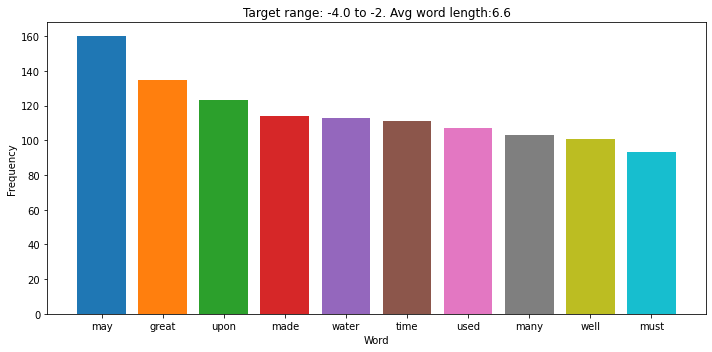

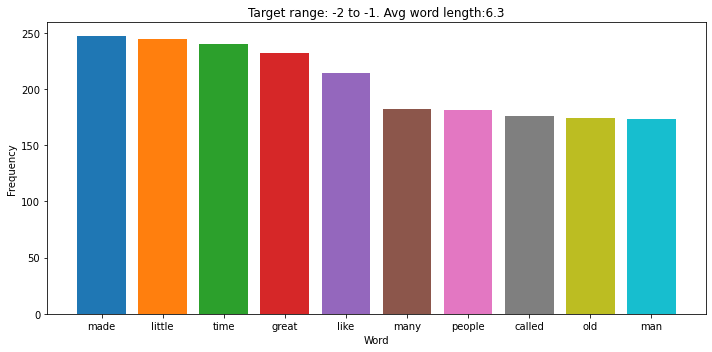

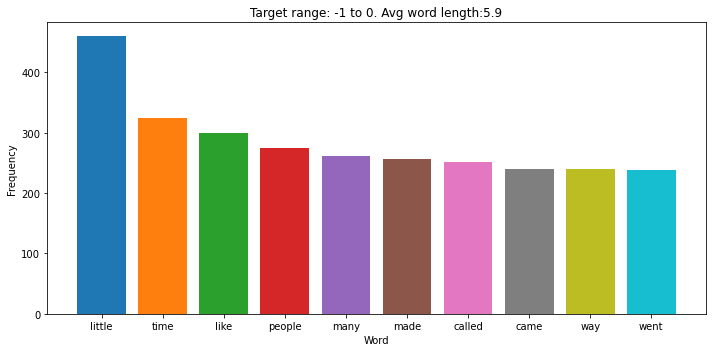

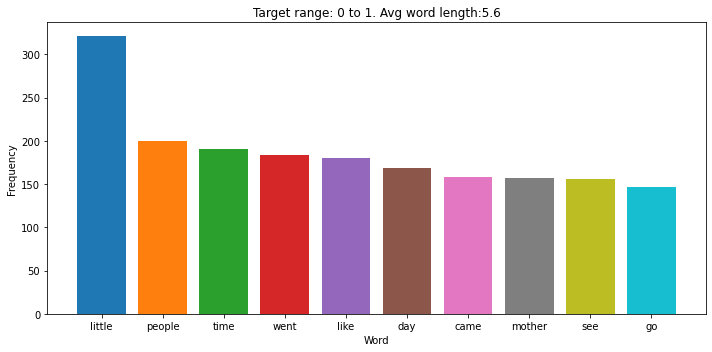

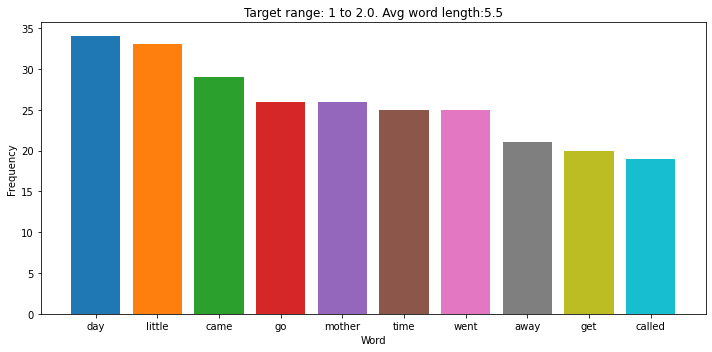

In [13]:
bounds = [(df['target'].min(), -2), (-2, -1), (-1,0), (0,1), (1,df['target'].max()+.01)]

for lr, ur in bounds:
    articles_concat = []

    for text in df[(df['target'] >= lr) & (df['target'] < ur)]['excerpt_tokenized']:
        articles_concat += text

    articles_freqdist = FreqDist(articles_concat)

    fig, ax = plt.subplots(figsize=(10,5))

    for i in range (0,10):
        plt.bar(articles_freqdist.most_common(10)[i][0], articles_freqdist.most_common(10)[i][1])

    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title(f'Target range: {round(lr,0)} to {round(ur,0)}. Avg word length:'
              f'{round(sum([len(i) for i in articles_concat])/len(articles_concat),1)}')
    ax.yaxis.set_major_formatter(
        tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))
    plt.tight_layout()
    print()

What about the `standard_error` field?

In [18]:
#exploring standard_error field
df.standard_error.describe()

count    2834.000000
mean        0.491435
std         0.034818
min         0.000000
25%         0.468543
50%         0.484721
75%         0.506268
max         0.649671
Name: standard_error, dtype: float64

In [19]:
#highest standard_error score text
df.excerpt[df[df.standard_error == df.standard_error.max()].index[0]]

'On the basis of the preceding comparisons some writers attempt to trace tentatively the history of the flood tradition current among the peoples of southwestern Asia. A fragment of the Babylonian flood story, coming from at least as early as 2000 B.C., has recently been discovered. The probability is that the tradition goes back to the earliest beginnings of Babylonian history. The setting of the Biblical accounts of the flood is also the Tigris-Euphrates valley rather than Palestine. The description of the construction of the ark in Genesis 6:14-16 is not only closely parallel to that found in the Babylonian account, but the method—the smearing of the ark within and without with bitumen—is peculiar to the Tigris-Euphrates valley. Many scholars believe, therefore, that Babylonia was the original home of the Biblical flood story.\nIts exact origin, however, is not so certain. Many of its details were doubtless suggested by the annual floods and fogs which inundate that famous valley an

In [20]:
#lowest standard_error score text
df.excerpt[df[df.standard_error == df.standard_error.min()].index[0]]

'The sun was shining in a cloudless sky, and no shadows lay on the mountain, and all day long they watched and waited, and at last, when the birds were singing their farewell song to the evening star, the children saw the shadows marching from the glen, trooping up the mountain side and dimming the purple of the heather.\nAnd when the mountain top gleamed like a golden spear, they fixed their eyes on the line between the shadow and the sunshine.\n"Now," said Connla, "the time has come."\n"Oh, look! look!" said Nora, and as she spoke, just above the line of shadow a door opened out, and through its portals came a little piper dressed in green and gold. He stepped down, followed by another and another, until they were nine in all, and then the door slung back again.'

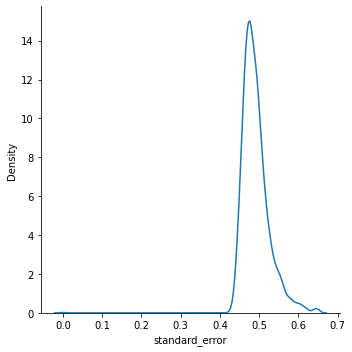

In [21]:
sns.displot(df, x="standard_error", kind="kde")

It seems that the `target` variable is more suitable to be modeled on. Let's proceed with our pre-modeling.

# Pre-modeling

In [22]:
#X and y variables for train/test split
X = df[['excerpt', 'excerpt_cleaned', 'excerpt_pos_lemmatized', 'excerpt_porter_stemmed', 'excerpt_snowball_stemmed', 
        'excerpt_lancaster_stemmed']]
y = df['target']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

Let's isolate which data is best for modeling.

In [24]:
columns = ['excerpt', 'excerpt_cleaned', 'excerpt_pos_lemmatized', 'excerpt_porter_stemmed', 'excerpt_snowball_stemmed', 
        'excerpt_lancaster_stemmed']

# build a term-document matrix with tf-idf weights for the terms
vect = TfidfVectorizer()
for col in columns:
    X_train_vect = vect.fit_transform(X_train[col])

    # train a linear regression model using stochastic gradient descent (SGD)
    regr = SGDRegressor()
    regr.fit(X_train_vect, y_train)

    cv_score = cross_val_score(regr, X_train_vect, y_train, cv = 5)
    print(f"{col} CV mean score: ", cv_score.mean())

excerpt CV mean score:  0.2888670402833208
excerpt_cleaned CV mean score:  0.1342863634794164
excerpt_pos_lemmatized CV mean score:  0.17089214591872687
excerpt_porter_stemmed CV mean score:  0.19382807396613302
excerpt_snowball_stemmed CV mean score:  0.1949981467493939
excerpt_lancaster_stemmed CV mean score:  0.21716622143086228


In [25]:
# build a term-document matrix with CountVectorizer
vect = CountVectorizer()
for col in columns:
    X_train_vect = vect.fit_transform(X_train[col])

    # train a linear regression model using stochastic gradient descent (SGD)
    regr = SGDRegressor()
    regr.fit(X_train_vect, y_train)

    cv_score = cross_val_score(regr, X_train_vect, y_train, cv = 5)
    print(f"{col} CV mean score: ", cv_score.mean())

excerpt CV mean score:  0.44136425975984406
excerpt_cleaned CV mean score:  0.3575388580794643
excerpt_pos_lemmatized CV mean score:  0.34587521459246673
excerpt_porter_stemmed CV mean score:  0.3442077143584833
excerpt_snowball_stemmed CV mean score:  0.346047610555549
excerpt_lancaster_stemmed CV mean score:  0.34651133353119024


Looks like the `excerpt` field produces the best results, so let's focus on this field.

In [26]:
#let's create a dataframe to save our modeling results
df_model_results = pd.DataFrame(columns=['Model Type', 'Modeled On', 'CV Score', 'RMSE'])
df_model_results

def evaluate_store_results(pipeline, variable, model_name):
    #break encapsulation
    global df_model_results
    
    #cross validate with 5 folds and make predictions on training set
    cv_results = np.median(cross_val_score(pipeline, X_train[variable], y_train, cv=5))
    y_pred = cross_val_predict(pipeline, X_train[variable], y_train, cv=5)
    

    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)
    
    #save model results
    model_results = {
    'Model Type': model_name,
    'Modeled On': variable, 
    'CV Score': cv_results,
    'RMSE': rmse
    }

    #append model results
    df_model_results = df_model_results.append(model_results, ignore_index=True)
    return df_model_results

# Modeling

Now let's explore different types of models.

In [27]:
LinearSVR_pipeline = Pipeline([('Vectorizer', CountVectorizer()),
              ('Linear SVR', LinearSVR())])


evaluate_store_results(LinearSVR_pipeline, 'excerpt', 'LinearSVR_CV')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215


In [28]:
LinearSVR_pipeline = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('Linear SVR', LinearSVR())])

evaluate_store_results(LinearSVR_pipeline, 'excerpt', 'LinearSVR_TF')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565


In [29]:
SGD_pipeline = Pipeline([('Vectorizer', CountVectorizer()),
              ('SGD', SGDRegressor())])

evaluate_store_results(SGD_pipeline, 'excerpt', 'SGD_CV')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813


In [30]:
SGD_pipeline = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('SGD', SGDRegressor())])

evaluate_store_results(SGD_pipeline, 'excerpt', 'SGD_TF')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731


In [31]:
DT_pipeline = Pipeline([('Vectorizer', CountVectorizer()),
              ('Decision Tree', DecisionTreeRegressor())])

evaluate_store_results(DT_pipeline, 'excerpt', 'DT_CV')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996


In [32]:
DT_pipeline = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('Decision Tree', DecisionTreeRegressor())])

evaluate_store_results(DT_pipeline, 'excerpt', 'DT_TF')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996
5,DT_TF,excerpt,-0.237940,1.169427


In [33]:
LR_pipeline = Pipeline([('Vectorizer', CountVectorizer()),
              ('Linear Regression', LinearRegression())])

evaluate_store_results(LR_pipeline, 'excerpt', 'LR_CV')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996
5,DT_TF,excerpt,-0.237940,1.169427
6,LR_CV,excerpt,0.424719,0.791941


In [34]:
LR_pipeline = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('Linear Regression', LinearRegression())])

evaluate_store_results(LR_pipeline, 'excerpt', 'LR_TF')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996
5,DT_TF,excerpt,-0.237940,1.169427
6,LR_CV,excerpt,0.424719,0.791941
7,LR_TF,excerpt,0.509525,0.739817


In [35]:
KNN_pipeline = Pipeline([('Vectorizer', CountVectorizer()),
              ('KNN', KNeighborsRegressor())])

evaluate_store_results(KNN_pipeline, 'excerpt', 'KNN_CV')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996
5,DT_TF,excerpt,-0.237940,1.169427
6,LR_CV,excerpt,0.424719,0.791941
7,LR_TF,excerpt,0.509525,0.739817
8,KNN_CV,excerpt,0.212911,0.914909


In [36]:
KNN_pipeline = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('KNN', KNeighborsRegressor())])

evaluate_store_results(KNN_pipeline, 'excerpt', 'KNN_TF')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996
5,DT_TF,excerpt,-0.237940,1.169427
6,LR_CV,excerpt,0.424719,0.791941
7,LR_TF,excerpt,0.509525,0.739817
8,KNN_CV,excerpt,0.212911,0.914909
9,KNN_TF,excerpt,0.289031,0.877081


In [37]:
RF_pipeline = Pipeline([('Vectorizer', CountVectorizer()),
              ('RF', RandomForestRegressor())])

evaluate_store_results(RF_pipeline, 'excerpt', 'RF_CV')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996
5,DT_TF,excerpt,-0.237940,1.169427
6,LR_CV,excerpt,0.424719,0.791941
7,LR_TF,excerpt,0.509525,0.739817
8,KNN_CV,excerpt,0.212911,0.914909
9,KNN_TF,excerpt,0.289031,0.877081


In [38]:
RF_pipeline = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('RF', RandomForestRegressor())])

evaluate_store_results(RF_pipeline, 'excerpt', 'RF_TF')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996
5,DT_TF,excerpt,-0.237940,1.169427
6,LR_CV,excerpt,0.424719,0.791941
7,LR_TF,excerpt,0.509525,0.739817
8,KNN_CV,excerpt,0.212911,0.914909
9,KNN_TF,excerpt,0.289031,0.877081


In [39]:
PAR_pipeline = Pipeline([('Vectorizer', CountVectorizer()),
              ('PAR', PassiveAggressiveRegressor())])

evaluate_store_results(PAR_pipeline, 'excerpt', 'PAR_CV')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996
5,DT_TF,excerpt,-0.237940,1.169427
6,LR_CV,excerpt,0.424719,0.791941
7,LR_TF,excerpt,0.509525,0.739817
8,KNN_CV,excerpt,0.212911,0.914909
9,KNN_TF,excerpt,0.289031,0.877081


In [40]:
PAR_pipeline = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('PAR', PassiveAggressiveRegressor())])

evaluate_store_results(PAR_pipeline, 'excerpt', 'PAR_TF')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996
5,DT_TF,excerpt,-0.237940,1.169427
6,LR_CV,excerpt,0.424719,0.791941
7,LR_TF,excerpt,0.509525,0.739817
8,KNN_CV,excerpt,0.212911,0.914909
9,KNN_TF,excerpt,0.289031,0.877081


In [41]:
import xgboost as xg

XGB_pipeline = Pipeline([('Vectorizer', CountVectorizer()),
              ('XGB', xg.XGBRegressor())])

evaluate_store_results(XGB_pipeline, 'excerpt', 'XGB_CV')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996
5,DT_TF,excerpt,-0.237940,1.169427
6,LR_CV,excerpt,0.424719,0.791941
7,LR_TF,excerpt,0.509525,0.739817
8,KNN_CV,excerpt,0.212911,0.914909
9,KNN_TF,excerpt,0.289031,0.877081


In [42]:
XGB_pipeline = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('XGB', xg.XGBRegressor())])

evaluate_store_results(XGB_pipeline, 'excerpt', 'XGB_TF')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996
5,DT_TF,excerpt,-0.237940,1.169427
6,LR_CV,excerpt,0.424719,0.791941
7,LR_TF,excerpt,0.509525,0.739817
8,KNN_CV,excerpt,0.212911,0.914909
9,KNN_TF,excerpt,0.289031,0.877081


In [43]:
ADA_pipeline = Pipeline([('Vectorizer', CountVectorizer()),
              ('ADA', AdaBoostRegressor())])

evaluate_store_results(ADA_pipeline, 'excerpt', 'ADA_CV')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996
5,DT_TF,excerpt,-0.237940,1.169427
6,LR_CV,excerpt,0.424719,0.791941
7,LR_TF,excerpt,0.509525,0.739817
8,KNN_CV,excerpt,0.212911,0.914909
9,KNN_TF,excerpt,0.289031,0.877081


In [44]:
ADA_pipeline = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('ADA', AdaBoostRegressor())])

evaluate_store_results(ADA_pipeline, 'excerpt', 'ADA_CV')

df_model_results

,Model Type,Modeled On,CV Score,RMSE
0,LinearSVR_CV,excerpt,0.423086,0.792215
1,LinearSVR_TF,excerpt,0.530766,0.722565
2,SGD_CV,excerpt,0.431232,0.778813
3,SGD_TF,excerpt,0.323148,0.852731
4,DT_CV,excerpt,-0.195505,1.137996
5,DT_TF,excerpt,-0.237940,1.169427
6,LR_CV,excerpt,0.424719,0.791941
7,LR_TF,excerpt,0.509525,0.739817
8,KNN_CV,excerpt,0.212911,0.914909
9,KNN_TF,excerpt,0.289031,0.877081


Looks like our LinearSVR_TF model performed the best, with an RMSE of .722567.

# Evaluation

Now let's train this model on the entire training set and then make predictions on the test set.

In [45]:
final_model_pipeline = Pipeline([('Vectorizer', CountVectorizer()),
              ('Linear SVR', LinearSVR())])

final_model_pipeline.fit(X_train['excerpt'], y_train)
y_pred = final_model_pipeline.predict(X_test['excerpt'])
score = final_model_pipeline.score(X_test['excerpt'], y_test)
  
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Test Set Accuracy: %.2f%%" % (score * 100))
print("Test Set RMSE: ", rmse)

Test Set Accuracy: 32.93%
Test Set RMSE:  0.8351686277890317


Our RMSE score is .835 on our test set. Let's predict on the validation set provided and submit this as our first submission.

In [46]:
#Import the test data
df_test = pd.read_csv('data/test.csv')
df_test

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at ..."
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,Milka and John are playing in the garden. Her ...


In [47]:
test_predictions = final_model_pipeline.predict(df_test['excerpt'])

In [48]:
test_predictions

array([-0.74655791, -0.81056224, -0.4001542 , -0.96154546, -1.11968325,
        0.38061963, -0.15497501])

In [49]:
data = {'id': df_test['id'].values,
        'target': test_predictions
       }

submission = pd.DataFrame(data)
submission

,id,target
0,c0f722661,-0.746558
1,f0953f0a5,-0.810562
2,0df072751,-0.400154
3,04caf4e0c,-0.961545
4,0e63f8bea,-1.119683
5,12537fe78,0.380620
6,965e592c0,-0.154975


In [50]:
#save our first submission
submission.to_csv(r'Submission.csv', index = False)

# Using HuggingFace Transformers and ktrain

Let's explore one of HuggingFace's pre-trained models and see if it lowers our RMSE.

In [51]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import ktrain
from ktrain import text

from transformers import AutoTokenizer, AutoModelWithLMHead
  
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

model = AutoModelWithLMHead.from_pretrained("xlnet-base-cased")

I chose a Transformer model at random, and decided to go with 'xlnet-base-cased'.

### Pre-processing / Training

In [52]:
#transform text using xlnet (case-sensative)
trans = text.Transformer('xlnet-base-cased', maxlen=512)

#preprocess our train/test split for our Transformer model
train_dataset = trans.preprocess_train(list(X_train['excerpt']), list(y_train))
test_dataset = trans.preprocess_test(list(X_test['excerpt']), list(y_test))

preprocessing train...
language: en
train sequence lengths:
	mean : 173
	95percentile : 198
	99percentile : 200


preprocessing test...
language: en
test sequence lengths:
	mean : 173
	95percentile : 198
	99percentile : 200


Now, we'll need to create a regression model, as well as the learner, in order to predict `target`.

In [53]:
#create model
model = trans.get_regression_model()

#create learner
learner = ktrain.get_learner(model, train_data=train_dataset, val_data=test_dataset, batch_size=6)

How do we know which learning rate is the best? Due to GPU constraints, I had to run this on Google Colab: https://github.com/dt1086/Kaggle---CommonLit-Readability-Prize/blob/master/Hugging_Face_Exploration.ipynb

Please refer to the "learner.lr_find(show_plot=True, max_epochs=10)" cell where the optimal learning rate was determined.

Using this optimal learning rate, let's start our training using this learning rate over just 1 epoch (due to timing constraint, more epochs could be used to improve accuracy).

In [54]:
learner.fit_onecycle(1e-4, 1)



begin training using onecycle policy with max lr of 0.0001...
355/355 [==============================] - 10261s 29s/step - loss: 0.6231 - mae: 0.6189 - val_loss: 0.3583 - val_mae: 0.4704


### Predict on new data

In [55]:
#create predictor
predictor = ktrain.get_predictor(learner.model, preproc=trans)

Let's reset our X_train indexes. Due to GPU constraints, using predictor.predict on the entire X_train dataset caused my computer to crash, so let's loop through the predictions manually.

In [56]:
#reset X_train indexes
X_train.reset_index(inplace=True)

In [57]:
#create empty list for y_predictions
y_pred = []

#iterate over each row and make a prediction and save into y_pred
for x in range(0,len(X_train)):
    train_predictions = predictor.predict(X_train['excerpt'][x])
    y_pred.append(train_predictions[0])

y_pred

[array([[0.15499552]], dtype=float32),
 array([[0.4496159]], dtype=float32),
 array([[-0.2987447]], dtype=float32),
 array([[-0.41173783]], dtype=float32),
 array([[0.05973957]], dtype=float32),
 array([[0.50618607]], dtype=float32),
 array([[0.22284019]], dtype=float32),
 array([[-2.3984995]], dtype=float32),
 array([[0.22814405]], dtype=float32),
 array([[-0.94372416]], dtype=float32),
 array([[-0.19846216]], dtype=float32),
 array([[-0.9285447]], dtype=float32),
 array([[-1.2516778]], dtype=float32),
 array([[-0.06051021]], dtype=float32),
 array([[0.13227987]], dtype=float32),
 array([[-1.1160043]], dtype=float32),
 array([[-2.3897343]], dtype=float32),
 array([[-1.8904822]], dtype=float32),
 array([[-0.7935567]], dtype=float32),
 array([[-0.11163138]], dtype=float32),
 array([[-0.2371639]], dtype=float32),
 array([[-2.051066]], dtype=float32),
 array([[-0.47866324]], dtype=float32),
 array([[-1.8249403]], dtype=float32),
 array([[-1.0661515]], dtype=float32),
 array([[0.05960105]]

Now, let's evaluate our RMSE on the training set.

In [58]:
#calculate training set RMSE
mse = mean_squared_error(y_train, pd.Series(y_pred))
rmse = np.sqrt(mse)

rmse

0.5235208145079878

.524, a great improvement! Now let's evaluate it on our test set.

In [61]:
#calculate testing set RMSE
y_pred = []

X_test.reset_index(inplace=True)

for x in range(0,len(X_test)):
    test_predictions = predictor.predict(X_test['excerpt'][x])
    y_pred.append(test_predictions[0])

mse = mean_squared_error(y_test, pd.Series(y_pred))
rmse = np.sqrt(mse)

rmse

0.5985428831118452

.599 RMSE on the testing set. A ~30% improvement!